## Import Libraries


In [67]:
import xgboost
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import *
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour, TomekLinks
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from catboost import CatBoostClassifier
from collections import defaultdict
from sklearn import tree
import matplotlib.pyplot as plt
import sklearn.metrics as metrics


## Read input csv file and remove quotes from customer id and merchant id

In [30]:
#Loading data from csv
rm_quote = lambda x: x.replace('\'', '')


data = pd.read_csv(r"data.csv", engine='python', converters={'customer': rm_quote, 'merchant': rm_quote, 'age': rm_quote, 'gender': rm_quote, 'zipMerchant': rm_quote, 'zipcodeOri': rm_quote})

data = data.rename(columns=rm_quote)

data.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,'es_transportation',4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,'es_transportation',39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,'es_transportation',26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,'es_transportation',17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,'es_transportation',35.72,0


## check frand and non-fraud percentage

In [31]:
total = data.shape[0]
normal = data[data.fraud == 0].step.count()
fraudulent = total - normal
print("total transactions = ",total)
print("non-fraud percentage = ",round(100*normal/total,2))
print("fraud percentage = ",round(100 *fraudulent/total,2))

total transactions =  594643
non-fraud percentage =  98.79
fraud percentage =  1.21


## Split data into features and target

In [32]:
target=data.fraud
features=data.drop('fraud',axis=1)
target.head()
features.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount
0,0,C1093826151,4,M,28007,M348934600,28007,'es_transportation',4.55
1,0,C352968107,2,M,28007,M348934600,28007,'es_transportation',39.68
2,0,C2054744914,4,F,28007,M1823072687,28007,'es_transportation',26.89
3,0,C1760612790,3,M,28007,M348934600,28007,'es_transportation',17.25
4,0,C757503768,5,M,28007,M348934600,28007,'es_transportation',35.72


## Drop features with only one or all unique values

In [33]:
features =  features.drop(['step','zipcodeOri', 'zipMerchant', 'customer'], axis = 1)
features.head()

,age,gender,merchant,category,amount
0,4,M,M348934600,'es_transportation',4.55
1,2,M,M348934600,'es_transportation',39.68
2,4,F,M1823072687,'es_transportation',26.89
3,3,M,M348934600,'es_transportation',17.25
4,5,M,M348934600,'es_transportation',35.72


## Check the distribution of "amount" feature

In [34]:
data['amount'].describe()

count    594643.000000
mean         37.890135
std         111.402831
min           0.000000
25%          13.740000
50%          26.900000
75%          42.540000
max        8329.960000
Name: amount, dtype: float64

## Apply MinMaxScalar on "amount" feature

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[['amount']] = scaler.fit_transform(data[['amount']])
data.head(100)
features.amount = data.amount
features.head()

,age,gender,merchant,category,amount
0,4,M,M348934600,'es_transportation',0.000546
1,2,M,M348934600,'es_transportation',0.004764
2,4,F,M1823072687,'es_transportation',0.003228
3,3,M,M348934600,'es_transportation',0.002071
4,5,M,M348934600,'es_transportation',0.004288


## Perform one hot encoding on the features

In [36]:
features_final = pd.get_dummies(features)
features_final.head()

,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,...,category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty'
0,0.000546,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.004764,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.003228,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.002071,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.004288,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Function for sampling

In [37]:
def hybrid_sampling(features, class_label):
    # Under sampling and over sampling
    osus = SMOTETomek(ratio=0.5, random_state=1)
    x_train_resample, y_train_resample = osus.fit_sample(features, class_label)
    return x_train_resample, y_train_resample


## Function to train the classifiers

In [38]:
def train_classifier(x_train_resample, y_train_resample, n_folds, classifiers):
    
    # k - fold cross validation
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(x_train_resample)
    
    f1_scores = {}
    accuracy = {}
    conf_matrix = {}  

    fold=0
    for train_index, test_index in kf.split(x_train_resample):
        fold += 1
        print("fold=", fold)
        X_train, X_test = x_train_resample.iloc[train_index], x_train_resample.iloc[test_index]
        y_train, y_test = y_train_resample.iloc[train_index], y_train_resample.iloc[test_index]

        predictions = {}
        f1_scores[fold] = {}
        accuracy[fold] = {}
        conf_matrix[fold] = {}  
        
        for classifier in classifiers:
            print("Classifier=", classifier)
            clf = eval(classifier)

            clf.fit(X_train, y_train)
            predictions[classifier] = clf.predict(X_test)

            # Making the Confusion Matrix
            conf_matrix[fold][classifier] = confusion_matrix(y_test, predictions[classifier])
            f1_scores[fold][classifier] = fbeta_score( y_test, predictions[classifier], average='macro', beta=1)
            accuracy[fold][classifier] = accuracy_score( y_test, predictions[classifier])

    return conf_matrix, f1_scores, accuracy


## Calculating average score of all crossvalidation scores of each model

In [39]:
def calculate_average_performance(data_dict):

    score = {} 
    fold_cnt = 0
    for fold, p_dict in data_dict.items():
        fold_cnt += 1
        for model, value in p_dict.items():
            if model in score:
                score[model] += value
            else:
                score[model] = value

    
    for model, value in score.items():
        score[model] = float(value) / float(fold_cnt)

    return score

## Parameter tuning for xgboost classifier

In [40]:
def tune_param(classifier):
    clf = eval(classifier)

    parameters = {  "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                    "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                    "min_child_weight" : [ 1, 3, 5, 7 ], 
                    "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                    "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

    scorer = make_scorer(fbeta_score, beta=1)
    grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, n_jobs=-1)
    grid_fit = grid_obj.fit(X_train, y_train)
    best_clf = grid_fit.best_estimator_
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    return best_predictions
    

## Train CLassifiers on original Features

In [41]:
confusion_matrix_orig, f1_scores_orig, accuracy_orig = train_classifier(features_final, target, 3, ["tree.DecisionTreeClassifier()","RandomForestClassifier(n_jobs=-1)", "xgboost.XGBClassifier(n_jobs=-1)", "CatBoostClassifier()"])

print(confusion_matrix_orig)
print("F- average", calculate_average_performance(f1_scores_orig))
print("Accuracy Average", calculate_average_performance(accuracy_orig))


fold= 1
Classifier= tree.DecisionTreeClassifier()
Classifier= RandomForestClassifier(n_jobs=-1)


c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier()
Learning rate set to 0.091076
0:	learn: 0.4680117	total: 279ms	remaining: 4m 38s
1:	learn: 0.3216472	total: 504ms	remaining: 4m 11s
2:	learn: 0.2212353	total: 723ms	remaining: 4m
3:	learn: 0.1527071	total: 972ms	remaining: 4m 1s
4:	learn: 0.1086584	total: 1.2s	remaining: 3m 59s
5:	learn: 0.0824147	total: 1.42s	remaining: 3m 55s
6:	learn: 0.0461924	total: 1.66s	remaining: 3m 55s
7:	learn: 0.0387772	total: 1.88s	remaining: 3m 53s
8:	learn: 0.0330937	total: 2.11s	remaining: 3m 52s
9:	learn: 0.0290453	total: 2.34s	remaining: 3m 51s
10:	learn: 0.0255323	total: 2.56s	remaining: 3m 50s
11:	learn: 0.0228965	total: 2.76s	remaining: 3m 46s
12:	learn: 0.0209585	total: 2.96s	remaining: 3m 44s
13:	learn: 0.0198755	total: 3.17s	remaining: 3m 43s
14:	learn: 0.0186937	total: 3.38s	remaining: 3m 42s
15:	learn: 0.0181183	total: 3.63s	remaining: 3m 43s
16:	learn: 0.0174745	total: 3.84s	remaining: 3m 42s
17:	learn: 0.0167021	tot

156:	learn: 0.0101310	total: 36.1s	remaining: 3m 13s
157:	learn: 0.0101236	total: 36.3s	remaining: 3m 13s
158:	learn: 0.0101153	total: 36.5s	remaining: 3m 13s
159:	learn: 0.0101096	total: 36.7s	remaining: 3m 12s
160:	learn: 0.0100995	total: 37s	remaining: 3m 12s
161:	learn: 0.0100922	total: 37.2s	remaining: 3m 12s
162:	learn: 0.0100880	total: 37.4s	remaining: 3m 12s
163:	learn: 0.0100835	total: 37.6s	remaining: 3m 11s
164:	learn: 0.0100764	total: 37.9s	remaining: 3m 11s
165:	learn: 0.0100719	total: 38.1s	remaining: 3m 11s
166:	learn: 0.0100660	total: 38.3s	remaining: 3m 11s
167:	learn: 0.0100598	total: 38.5s	remaining: 3m 10s
168:	learn: 0.0100472	total: 38.7s	remaining: 3m 10s
169:	learn: 0.0100410	total: 38.9s	remaining: 3m 10s
170:	learn: 0.0100269	total: 39.2s	remaining: 3m 9s
171:	learn: 0.0100158	total: 39.4s	remaining: 3m 9s
172:	learn: 0.0100092	total: 39.6s	remaining: 3m 9s
173:	learn: 0.0100045	total: 39.8s	remaining: 3m 8s
174:	learn: 0.0099927	total: 40s	remaining: 3m 8s
17

313:	learn: 0.0092643	total: 1m 10s	remaining: 2m 34s
314:	learn: 0.0092595	total: 1m 10s	remaining: 2m 33s
315:	learn: 0.0092578	total: 1m 10s	remaining: 2m 33s
316:	learn: 0.0092561	total: 1m 11s	remaining: 2m 33s
317:	learn: 0.0092532	total: 1m 11s	remaining: 2m 33s
318:	learn: 0.0092481	total: 1m 11s	remaining: 2m 32s
319:	learn: 0.0092435	total: 1m 11s	remaining: 2m 32s
320:	learn: 0.0092383	total: 1m 12s	remaining: 2m 32s
321:	learn: 0.0092368	total: 1m 12s	remaining: 2m 32s
322:	learn: 0.0092309	total: 1m 12s	remaining: 2m 31s
323:	learn: 0.0092292	total: 1m 12s	remaining: 2m 31s
324:	learn: 0.0092253	total: 1m 12s	remaining: 2m 31s
325:	learn: 0.0092236	total: 1m 13s	remaining: 2m 31s
326:	learn: 0.0092189	total: 1m 13s	remaining: 2m 31s
327:	learn: 0.0092120	total: 1m 13s	remaining: 2m 30s
328:	learn: 0.0092104	total: 1m 13s	remaining: 2m 30s
329:	learn: 0.0092057	total: 1m 14s	remaining: 2m 30s
330:	learn: 0.0092016	total: 1m 14s	remaining: 2m 30s
331:	learn: 0.0091983	total:

466:	learn: 0.0087666	total: 1m 44s	remaining: 1m 59s
467:	learn: 0.0087639	total: 1m 44s	remaining: 1m 58s
468:	learn: 0.0087609	total: 1m 44s	remaining: 1m 58s
469:	learn: 0.0087589	total: 1m 45s	remaining: 1m 58s
470:	learn: 0.0087561	total: 1m 45s	remaining: 1m 58s
471:	learn: 0.0087544	total: 1m 45s	remaining: 1m 57s
472:	learn: 0.0087515	total: 1m 45s	remaining: 1m 57s
473:	learn: 0.0087504	total: 1m 45s	remaining: 1m 57s
474:	learn: 0.0087492	total: 1m 46s	remaining: 1m 57s
475:	learn: 0.0087452	total: 1m 46s	remaining: 1m 57s
476:	learn: 0.0087431	total: 1m 46s	remaining: 1m 56s
477:	learn: 0.0087398	total: 1m 46s	remaining: 1m 56s
478:	learn: 0.0087385	total: 1m 47s	remaining: 1m 56s
479:	learn: 0.0087365	total: 1m 47s	remaining: 1m 56s
480:	learn: 0.0087352	total: 1m 47s	remaining: 1m 55s
481:	learn: 0.0087336	total: 1m 47s	remaining: 1m 55s
482:	learn: 0.0087323	total: 1m 47s	remaining: 1m 55s
483:	learn: 0.0087272	total: 1m 48s	remaining: 1m 55s
484:	learn: 0.0087258	total:

619:	learn: 0.0084210	total: 2m 18s	remaining: 1m 25s
620:	learn: 0.0084188	total: 2m 19s	remaining: 1m 24s
621:	learn: 0.0084175	total: 2m 19s	remaining: 1m 24s
622:	learn: 0.0084155	total: 2m 19s	remaining: 1m 24s
623:	learn: 0.0084146	total: 2m 19s	remaining: 1m 24s
624:	learn: 0.0084123	total: 2m 20s	remaining: 1m 24s
625:	learn: 0.0084106	total: 2m 20s	remaining: 1m 23s
626:	learn: 0.0084089	total: 2m 20s	remaining: 1m 23s
627:	learn: 0.0084079	total: 2m 20s	remaining: 1m 23s
628:	learn: 0.0084062	total: 2m 20s	remaining: 1m 23s
629:	learn: 0.0084034	total: 2m 21s	remaining: 1m 22s
630:	learn: 0.0083993	total: 2m 21s	remaining: 1m 22s
631:	learn: 0.0083979	total: 2m 21s	remaining: 1m 22s
632:	learn: 0.0083955	total: 2m 21s	remaining: 1m 22s
633:	learn: 0.0083937	total: 2m 21s	remaining: 1m 21s
634:	learn: 0.0083921	total: 2m 22s	remaining: 1m 21s
635:	learn: 0.0083895	total: 2m 22s	remaining: 1m 21s
636:	learn: 0.0083875	total: 2m 22s	remaining: 1m 21s
637:	learn: 0.0083855	total:

773:	learn: 0.0081390	total: 2m 52s	remaining: 50.5s
774:	learn: 0.0081365	total: 2m 53s	remaining: 50.2s
775:	learn: 0.0081354	total: 2m 53s	remaining: 50s
776:	learn: 0.0081336	total: 2m 53s	remaining: 49.8s
777:	learn: 0.0081321	total: 2m 53s	remaining: 49.5s
778:	learn: 0.0081301	total: 2m 53s	remaining: 49.3s
779:	learn: 0.0081290	total: 2m 54s	remaining: 49.1s
780:	learn: 0.0081278	total: 2m 54s	remaining: 48.9s
781:	learn: 0.0081268	total: 2m 54s	remaining: 48.7s
782:	learn: 0.0081237	total: 2m 54s	remaining: 48.4s
783:	learn: 0.0081217	total: 2m 54s	remaining: 48.2s
784:	learn: 0.0081206	total: 2m 55s	remaining: 48s
785:	learn: 0.0081193	total: 2m 55s	remaining: 47.8s
786:	learn: 0.0081188	total: 2m 55s	remaining: 47.5s
787:	learn: 0.0081175	total: 2m 55s	remaining: 47.3s
788:	learn: 0.0081154	total: 2m 56s	remaining: 47.1s
789:	learn: 0.0081136	total: 2m 56s	remaining: 46.9s
790:	learn: 0.0081119	total: 2m 56s	remaining: 46.6s
791:	learn: 0.0081108	total: 2m 56s	remaining: 46.

930:	learn: 0.0079133	total: 3m 29s	remaining: 15.5s
931:	learn: 0.0079126	total: 3m 29s	remaining: 15.3s
932:	learn: 0.0079106	total: 3m 30s	remaining: 15.1s
933:	learn: 0.0079093	total: 3m 30s	remaining: 14.9s
934:	learn: 0.0079081	total: 3m 30s	remaining: 14.6s
935:	learn: 0.0079063	total: 3m 30s	remaining: 14.4s
936:	learn: 0.0079034	total: 3m 31s	remaining: 14.2s
937:	learn: 0.0079021	total: 3m 31s	remaining: 14s
938:	learn: 0.0079014	total: 3m 31s	remaining: 13.7s
939:	learn: 0.0078998	total: 3m 31s	remaining: 13.5s
940:	learn: 0.0078993	total: 3m 32s	remaining: 13.3s
941:	learn: 0.0078970	total: 3m 32s	remaining: 13.1s
942:	learn: 0.0078966	total: 3m 32s	remaining: 12.9s
943:	learn: 0.0078961	total: 3m 32s	remaining: 12.6s
944:	learn: 0.0078956	total: 3m 33s	remaining: 12.4s
945:	learn: 0.0078951	total: 3m 33s	remaining: 12.2s
946:	learn: 0.0078944	total: 3m 33s	remaining: 11.9s
947:	learn: 0.0078923	total: 3m 33s	remaining: 11.7s
948:	learn: 0.0078916	total: 3m 34s	remaining: 1

c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier()
Learning rate set to 0.091076
0:	learn: 0.4609808	total: 218ms	remaining: 3m 38s
1:	learn: 0.2302070	total: 443ms	remaining: 3m 41s
2:	learn: 0.1217459	total: 677ms	remaining: 3m 45s
3:	learn: 0.0699262	total: 903ms	remaining: 3m 44s
4:	learn: 0.0461851	total: 1.17s	remaining: 3m 51s
5:	learn: 0.0344300	total: 1.37s	remaining: 3m 47s
6:	learn: 0.0281713	total: 1.59s	remaining: 3m 45s
7:	learn: 0.0247122	total: 1.81s	remaining: 3m 44s
8:	learn: 0.0223320	total: 2.02s	remaining: 3m 42s
9:	learn: 0.0209423	total: 2.24s	remaining: 3m 41s
10:	learn: 0.0198206	total: 2.47s	remaining: 3m 42s
11:	learn: 0.0189868	total: 2.7s	remaining: 3m 42s
12:	learn: 0.0182684	total: 2.92s	remaining: 3m 41s
13:	learn: 0.0178373	total: 3.13s	remaining: 3m 40s
14:	learn: 0.0170455	total: 3.35s	remaining: 3m 40s
15:	learn: 0.0167496	total: 3.58s	remaining: 3m 39s
16:	learn: 0.0164818	total: 3.79s	remaining: 3m 38s
17:	learn: 0.016182

157:	learn: 0.0114517	total: 31.6s	remaining: 2m 48s
158:	learn: 0.0114486	total: 31.7s	remaining: 2m 47s
159:	learn: 0.0114445	total: 31.9s	remaining: 2m 47s
160:	learn: 0.0114334	total: 32s	remaining: 2m 46s
161:	learn: 0.0114305	total: 32.1s	remaining: 2m 46s
162:	learn: 0.0114207	total: 32.2s	remaining: 2m 45s
163:	learn: 0.0114161	total: 32.3s	remaining: 2m 44s
164:	learn: 0.0114103	total: 32.4s	remaining: 2m 44s
165:	learn: 0.0114018	total: 32.6s	remaining: 2m 43s
166:	learn: 0.0113961	total: 32.7s	remaining: 2m 43s
167:	learn: 0.0113859	total: 32.8s	remaining: 2m 42s
168:	learn: 0.0113811	total: 32.9s	remaining: 2m 41s
169:	learn: 0.0113777	total: 33s	remaining: 2m 41s
170:	learn: 0.0113746	total: 33.2s	remaining: 2m 40s
171:	learn: 0.0113676	total: 33.3s	remaining: 2m 40s
172:	learn: 0.0113642	total: 33.4s	remaining: 2m 39s
173:	learn: 0.0113612	total: 33.5s	remaining: 2m 39s
174:	learn: 0.0113555	total: 33.7s	remaining: 2m 38s
175:	learn: 0.0113459	total: 33.8s	remaining: 2m 3

315:	learn: 0.0107918	total: 51.2s	remaining: 1m 50s
316:	learn: 0.0107873	total: 51.3s	remaining: 1m 50s
317:	learn: 0.0107822	total: 51.5s	remaining: 1m 50s
318:	learn: 0.0107804	total: 51.6s	remaining: 1m 50s
319:	learn: 0.0107769	total: 51.7s	remaining: 1m 49s
320:	learn: 0.0107738	total: 51.8s	remaining: 1m 49s
321:	learn: 0.0107715	total: 52s	remaining: 1m 49s
322:	learn: 0.0107695	total: 52.1s	remaining: 1m 49s
323:	learn: 0.0107670	total: 52.2s	remaining: 1m 48s
324:	learn: 0.0107611	total: 52.3s	remaining: 1m 48s
325:	learn: 0.0107597	total: 52.4s	remaining: 1m 48s
326:	learn: 0.0107569	total: 52.6s	remaining: 1m 48s
327:	learn: 0.0107554	total: 52.7s	remaining: 1m 47s
328:	learn: 0.0107533	total: 52.8s	remaining: 1m 47s
329:	learn: 0.0107482	total: 52.9s	remaining: 1m 47s
330:	learn: 0.0107460	total: 53s	remaining: 1m 47s
331:	learn: 0.0107424	total: 53.2s	remaining: 1m 46s
332:	learn: 0.0107401	total: 53.3s	remaining: 1m 46s
333:	learn: 0.0107368	total: 53.4s	remaining: 1m 4

471:	learn: 0.0103924	total: 1m 10s	remaining: 1m 19s
472:	learn: 0.0103906	total: 1m 10s	remaining: 1m 19s
473:	learn: 0.0103888	total: 1m 11s	remaining: 1m 18s
474:	learn: 0.0103880	total: 1m 11s	remaining: 1m 18s
475:	learn: 0.0103829	total: 1m 11s	remaining: 1m 18s
476:	learn: 0.0103815	total: 1m 11s	remaining: 1m 18s
477:	learn: 0.0103788	total: 1m 11s	remaining: 1m 18s
478:	learn: 0.0103755	total: 1m 11s	remaining: 1m 17s
479:	learn: 0.0103726	total: 1m 11s	remaining: 1m 17s
480:	learn: 0.0103716	total: 1m 11s	remaining: 1m 17s
481:	learn: 0.0103705	total: 1m 12s	remaining: 1m 17s
482:	learn: 0.0103682	total: 1m 12s	remaining: 1m 17s
483:	learn: 0.0103672	total: 1m 12s	remaining: 1m 17s
484:	learn: 0.0103662	total: 1m 12s	remaining: 1m 16s
485:	learn: 0.0103640	total: 1m 12s	remaining: 1m 16s
486:	learn: 0.0103616	total: 1m 12s	remaining: 1m 16s
487:	learn: 0.0103595	total: 1m 12s	remaining: 1m 16s
488:	learn: 0.0103556	total: 1m 12s	remaining: 1m 16s
489:	learn: 0.0103525	total:

627:	learn: 0.0100754	total: 1m 30s	remaining: 53.3s
628:	learn: 0.0100734	total: 1m 30s	remaining: 53.2s
629:	learn: 0.0100708	total: 1m 30s	remaining: 53s
630:	learn: 0.0100702	total: 1m 30s	remaining: 52.9s
631:	learn: 0.0100693	total: 1m 30s	remaining: 52.7s
632:	learn: 0.0100677	total: 1m 30s	remaining: 52.6s
633:	learn: 0.0100666	total: 1m 30s	remaining: 52.4s
634:	learn: 0.0100639	total: 1m 30s	remaining: 52.2s
635:	learn: 0.0100625	total: 1m 31s	remaining: 52.1s
636:	learn: 0.0100599	total: 1m 31s	remaining: 51.9s
637:	learn: 0.0100577	total: 1m 31s	remaining: 51.8s
638:	learn: 0.0100565	total: 1m 31s	remaining: 51.6s
639:	learn: 0.0100550	total: 1m 31s	remaining: 51.5s
640:	learn: 0.0100529	total: 1m 31s	remaining: 51.3s
641:	learn: 0.0100511	total: 1m 31s	remaining: 51.2s
642:	learn: 0.0100494	total: 1m 31s	remaining: 51s
643:	learn: 0.0100479	total: 1m 32s	remaining: 50.9s
644:	learn: 0.0100464	total: 1m 32s	remaining: 50.7s
645:	learn: 0.0100443	total: 1m 32s	remaining: 50.

783:	learn: 0.0098276	total: 1m 50s	remaining: 30.3s
784:	learn: 0.0098272	total: 1m 50s	remaining: 30.2s
785:	learn: 0.0098252	total: 1m 50s	remaining: 30s
786:	learn: 0.0098239	total: 1m 50s	remaining: 29.9s
787:	learn: 0.0098237	total: 1m 50s	remaining: 29.7s
788:	learn: 0.0098224	total: 1m 50s	remaining: 29.6s
789:	learn: 0.0098219	total: 1m 50s	remaining: 29.5s
790:	learn: 0.0098208	total: 1m 50s	remaining: 29.3s
791:	learn: 0.0098199	total: 1m 51s	remaining: 29.2s
792:	learn: 0.0098179	total: 1m 51s	remaining: 29s
793:	learn: 0.0098172	total: 1m 51s	remaining: 28.9s
794:	learn: 0.0098154	total: 1m 51s	remaining: 28.7s
795:	learn: 0.0098143	total: 1m 51s	remaining: 28.6s
796:	learn: 0.0098132	total: 1m 51s	remaining: 28.5s
797:	learn: 0.0098119	total: 1m 51s	remaining: 28.3s
798:	learn: 0.0098109	total: 1m 52s	remaining: 28.2s
799:	learn: 0.0098086	total: 1m 52s	remaining: 28s
800:	learn: 0.0098075	total: 1m 52s	remaining: 27.9s
801:	learn: 0.0098068	total: 1m 52s	remaining: 27.7s

941:	learn: 0.0096282	total: 2m 10s	remaining: 8.01s
942:	learn: 0.0096268	total: 2m 10s	remaining: 7.87s
943:	learn: 0.0096252	total: 2m 10s	remaining: 7.74s
944:	learn: 0.0096248	total: 2m 10s	remaining: 7.6s
945:	learn: 0.0096242	total: 2m 10s	remaining: 7.46s
946:	learn: 0.0096235	total: 2m 10s	remaining: 7.32s
947:	learn: 0.0096221	total: 2m 10s	remaining: 7.18s
948:	learn: 0.0096209	total: 2m 11s	remaining: 7.04s
949:	learn: 0.0096199	total: 2m 11s	remaining: 6.9s
950:	learn: 0.0096163	total: 2m 11s	remaining: 6.76s
951:	learn: 0.0096146	total: 2m 11s	remaining: 6.63s
952:	learn: 0.0096121	total: 2m 11s	remaining: 6.49s
953:	learn: 0.0096114	total: 2m 11s	remaining: 6.35s
954:	learn: 0.0096092	total: 2m 11s	remaining: 6.21s
955:	learn: 0.0096072	total: 2m 11s	remaining: 6.07s
956:	learn: 0.0096061	total: 2m 12s	remaining: 5.93s
957:	learn: 0.0096051	total: 2m 12s	remaining: 5.79s
958:	learn: 0.0096044	total: 2m 12s	remaining: 5.66s
959:	learn: 0.0096031	total: 2m 12s	remaining: 5

c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier()
Learning rate set to 0.091076
0:	learn: 0.4651233	total: 124ms	remaining: 2m 3s
1:	learn: 0.2373592	total: 236ms	remaining: 1m 57s
2:	learn: 0.1290307	total: 353ms	remaining: 1m 57s
3:	learn: 0.0762478	total: 472ms	remaining: 1m 57s
4:	learn: 0.0514542	total: 600ms	remaining: 1m 59s
5:	learn: 0.0389866	total: 714ms	remaining: 1m 58s
6:	learn: 0.0318934	total: 838ms	remaining: 1m 58s
7:	learn: 0.0275853	total: 972ms	remaining: 2m
8:	learn: 0.0248067	total: 1.09s	remaining: 2m
9:	learn: 0.0229621	total: 1.21s	remaining: 1m 59s
10:	learn: 0.0215255	total: 1.33s	remaining: 1m 59s
11:	learn: 0.0204539	total: 1.44s	remaining: 1m 58s
12:	learn: 0.0196328	total: 1.56s	remaining: 1m 58s
13:	learn: 0.0183883	total: 1.7s	remaining: 1m 59s
14:	learn: 0.0179758	total: 1.82s	remaining: 1m 59s
15:	learn: 0.0176611	total: 1.93s	remaining: 1m 58s
16:	learn: 0.0172850	total: 2.06s	remaining: 1m 58s
17:	learn: 0.0169708	total: 

156:	learn: 0.0124808	total: 21.1s	remaining: 1m 53s
157:	learn: 0.0124724	total: 21.3s	remaining: 1m 53s
158:	learn: 0.0124636	total: 21.4s	remaining: 1m 53s
159:	learn: 0.0124591	total: 21.6s	remaining: 1m 53s
160:	learn: 0.0124485	total: 21.7s	remaining: 1m 52s
161:	learn: 0.0124426	total: 21.8s	remaining: 1m 52s
162:	learn: 0.0124371	total: 22s	remaining: 1m 52s
163:	learn: 0.0124228	total: 22.1s	remaining: 1m 52s
164:	learn: 0.0124139	total: 22.3s	remaining: 1m 52s
165:	learn: 0.0124093	total: 22.4s	remaining: 1m 52s
166:	learn: 0.0124021	total: 22.5s	remaining: 1m 52s
167:	learn: 0.0123986	total: 22.7s	remaining: 1m 52s
168:	learn: 0.0123887	total: 22.8s	remaining: 1m 52s
169:	learn: 0.0123831	total: 23s	remaining: 1m 52s
170:	learn: 0.0123744	total: 23.1s	remaining: 1m 51s
171:	learn: 0.0123655	total: 23.2s	remaining: 1m 51s
172:	learn: 0.0123618	total: 23.3s	remaining: 1m 51s
173:	learn: 0.0123558	total: 23.5s	remaining: 1m 51s
174:	learn: 0.0123504	total: 23.6s	remaining: 1m 5

313:	learn: 0.0116683	total: 43.1s	remaining: 1m 34s
314:	learn: 0.0116648	total: 43.2s	remaining: 1m 33s
315:	learn: 0.0116593	total: 43.4s	remaining: 1m 33s
316:	learn: 0.0116553	total: 43.5s	remaining: 1m 33s
317:	learn: 0.0116494	total: 43.6s	remaining: 1m 33s
318:	learn: 0.0116472	total: 43.7s	remaining: 1m 33s
319:	learn: 0.0116427	total: 43.9s	remaining: 1m 33s
320:	learn: 0.0116397	total: 44s	remaining: 1m 33s
321:	learn: 0.0116373	total: 44.1s	remaining: 1m 32s
322:	learn: 0.0116334	total: 44.2s	remaining: 1m 32s
323:	learn: 0.0116306	total: 44.4s	remaining: 1m 32s
324:	learn: 0.0116266	total: 44.5s	remaining: 1m 32s
325:	learn: 0.0116252	total: 44.6s	remaining: 1m 32s
326:	learn: 0.0116200	total: 44.7s	remaining: 1m 32s
327:	learn: 0.0116160	total: 44.9s	remaining: 1m 31s
328:	learn: 0.0116087	total: 45s	remaining: 1m 31s
329:	learn: 0.0116071	total: 45.1s	remaining: 1m 31s
330:	learn: 0.0116031	total: 45.3s	remaining: 1m 31s
331:	learn: 0.0116008	total: 45.4s	remaining: 1m 3

469:	learn: 0.0112488	total: 1m 3s	remaining: 1m 11s
470:	learn: 0.0112464	total: 1m 3s	remaining: 1m 11s
471:	learn: 0.0112438	total: 1m 3s	remaining: 1m 10s
472:	learn: 0.0112420	total: 1m 3s	remaining: 1m 10s
473:	learn: 0.0112404	total: 1m 3s	remaining: 1m 10s
474:	learn: 0.0112391	total: 1m 3s	remaining: 1m 10s
475:	learn: 0.0112337	total: 1m 3s	remaining: 1m 10s
476:	learn: 0.0112312	total: 1m 4s	remaining: 1m 10s
477:	learn: 0.0112302	total: 1m 4s	remaining: 1m 10s
478:	learn: 0.0112287	total: 1m 4s	remaining: 1m 9s
479:	learn: 0.0112281	total: 1m 4s	remaining: 1m 9s
480:	learn: 0.0112225	total: 1m 4s	remaining: 1m 9s
481:	learn: 0.0112211	total: 1m 4s	remaining: 1m 9s
482:	learn: 0.0112201	total: 1m 4s	remaining: 1m 9s
483:	learn: 0.0112173	total: 1m 5s	remaining: 1m 9s
484:	learn: 0.0112151	total: 1m 5s	remaining: 1m 9s
485:	learn: 0.0112117	total: 1m 5s	remaining: 1m 9s
486:	learn: 0.0112096	total: 1m 5s	remaining: 1m 8s
487:	learn: 0.0112083	total: 1m 5s	remaining: 1m 8s
488

627:	learn: 0.0108929	total: 1m 24s	remaining: 50.2s
628:	learn: 0.0108911	total: 1m 24s	remaining: 50s
629:	learn: 0.0108903	total: 1m 24s	remaining: 49.9s
630:	learn: 0.0108892	total: 1m 25s	remaining: 49.7s
631:	learn: 0.0108857	total: 1m 25s	remaining: 49.6s
632:	learn: 0.0108826	total: 1m 25s	remaining: 49.5s
633:	learn: 0.0108815	total: 1m 25s	remaining: 49.3s
634:	learn: 0.0108786	total: 1m 25s	remaining: 49.2s
635:	learn: 0.0108776	total: 1m 25s	remaining: 49.1s
636:	learn: 0.0108757	total: 1m 25s	remaining: 48.9s
637:	learn: 0.0108734	total: 1m 25s	remaining: 48.8s
638:	learn: 0.0108694	total: 1m 26s	remaining: 48.7s
639:	learn: 0.0108666	total: 1m 26s	remaining: 48.5s
640:	learn: 0.0108643	total: 1m 26s	remaining: 48.4s
641:	learn: 0.0108632	total: 1m 26s	remaining: 48.3s
642:	learn: 0.0108624	total: 1m 26s	remaining: 48.1s
643:	learn: 0.0108613	total: 1m 26s	remaining: 48s
644:	learn: 0.0108595	total: 1m 26s	remaining: 47.8s
645:	learn: 0.0108576	total: 1m 27s	remaining: 47.

783:	learn: 0.0106393	total: 1m 45s	remaining: 29s
784:	learn: 0.0106388	total: 1m 45s	remaining: 28.8s
785:	learn: 0.0106372	total: 1m 45s	remaining: 28.7s
786:	learn: 0.0106366	total: 1m 45s	remaining: 28.6s
787:	learn: 0.0106360	total: 1m 45s	remaining: 28.4s
788:	learn: 0.0106346	total: 1m 45s	remaining: 28.3s
789:	learn: 0.0106327	total: 1m 45s	remaining: 28.1s
790:	learn: 0.0106315	total: 1m 46s	remaining: 28s
791:	learn: 0.0106303	total: 1m 46s	remaining: 27.9s
792:	learn: 0.0106277	total: 1m 46s	remaining: 27.7s
793:	learn: 0.0106272	total: 1m 46s	remaining: 27.6s
794:	learn: 0.0106247	total: 1m 46s	remaining: 27.5s
795:	learn: 0.0106241	total: 1m 46s	remaining: 27.3s
796:	learn: 0.0106228	total: 1m 46s	remaining: 27.2s
797:	learn: 0.0106199	total: 1m 46s	remaining: 27.1s
798:	learn: 0.0106189	total: 1m 47s	remaining: 26.9s
799:	learn: 0.0106174	total: 1m 47s	remaining: 26.8s
800:	learn: 0.0106162	total: 1m 47s	remaining: 26.6s
801:	learn: 0.0106129	total: 1m 47s	remaining: 26.

941:	learn: 0.0104037	total: 2m 6s	remaining: 7.78s
942:	learn: 0.0104025	total: 2m 6s	remaining: 7.64s
943:	learn: 0.0103986	total: 2m 6s	remaining: 7.51s
944:	learn: 0.0103978	total: 2m 6s	remaining: 7.38s
945:	learn: 0.0103971	total: 2m 6s	remaining: 7.24s
946:	learn: 0.0103956	total: 2m 7s	remaining: 7.11s
947:	learn: 0.0103943	total: 2m 7s	remaining: 6.97s
948:	learn: 0.0103937	total: 2m 7s	remaining: 6.84s
949:	learn: 0.0103917	total: 2m 7s	remaining: 6.71s
950:	learn: 0.0103914	total: 2m 7s	remaining: 6.57s
951:	learn: 0.0103897	total: 2m 7s	remaining: 6.44s
952:	learn: 0.0103890	total: 2m 7s	remaining: 6.3s
953:	learn: 0.0103880	total: 2m 7s	remaining: 6.17s
954:	learn: 0.0103860	total: 2m 8s	remaining: 6.03s
955:	learn: 0.0103843	total: 2m 8s	remaining: 5.9s
956:	learn: 0.0103837	total: 2m 8s	remaining: 5.77s
957:	learn: 0.0103825	total: 2m 8s	remaining: 5.63s
958:	learn: 0.0103816	total: 2m 8s	remaining: 5.5s
959:	learn: 0.0103790	total: 2m 8s	remaining: 5.36s
960:	learn: 0.0

## Read Graph Features

In [42]:
df_features_cust = pd.read_csv(r"customer_features.csv")
df_features_cust.head()

df_features_mrc = pd.read_csv(r"merchant_features.csv")
df_features_mrc.head()


,merchant,mer_degree,mer_pagerank,mer_community
0,M1053599405,2829,32.429804,4
1,M117188757,20,0.347098,24
2,M1198415165,1010,10.574918,20
3,M1294758098,146,1.433058,41
4,M1313686961,483,5.451986,34


## Merge features with original dataframe

In [43]:
df_merged = pd.merge(data, df_features_cust, on=['customer'], how='left')

df_merged = pd.merge(df_merged, df_features_mrc, on=['merchant'], how='left')

df_merged =  df_merged.drop(['step','zipcodeOri', 'zipMerchant', 'customer'], axis = 1)

df_merged.head()



,age,gender,merchant,category,amount,fraud,cust_degree,cust_pagerank,cust_community,mer_degree,mer_pagerank,mer_community
0,4,M,M348934600,'es_transportation',0.000546,0,7,0.15,44,3929,46.528797,0
1,2,M,M348934600,'es_transportation',0.004764,0,12,0.15,42,3929,46.528797,0
2,4,F,M1823072687,'es_transportation',0.003228,0,14,0.15,42,3573,41.379700,1
3,3,M,M348934600,'es_transportation',0.002071,0,11,0.15,42,3929,46.528797,0
4,5,M,M348934600,'es_transportation',0.004288,0,14,0.15,40,3929,46.528797,0


In [44]:
target=df_merged.fraud
features=df_merged.drop('fraud',axis=1)

features_final = pd.get_dummies(features)


target.head()
features_final.head()


,amount,cust_degree,cust_pagerank,cust_community,mer_degree,mer_pagerank,mer_community,age_0,age_1,age_2,...,category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty'
0,0.000546,7,0.15,44,3929,46.528797,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.004764,12,0.15,42,3929,46.528797,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.003228,14,0.15,42,3573,41.379700,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.002071,11,0.15,42,3929,46.528797,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.004288,14,0.15,40,3929,46.528797,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Train Classifier again with new features

In [46]:
confusion_matrix, f1_scores, accuracy = train_classifier(features_final, target, 3, ["tree.DecisionTreeClassifier()","RandomForestClassifier(n_jobs=-1)", "xgboost.XGBClassifier(n_jobs=-1)", "CatBoostClassifier()"])

# confusion_matrix, f1_scores, accuracy = train_classifier(features_final, target, 3, ["RandomForestClassifier", "xgboost.XGBClassifier", "CatBoostClassifier"])


# confusion_matrix, f1_scores, accuracy = train_classifier(features, target, 3, ["CatBoostClassifier"])


fold= 1
Classifier= tree.DecisionTreeClassifier()
Classifier= RandomForestClassifier(n_jobs=-1)


c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier()
Learning rate set to 0.091076
0:	learn: 0.4106539	total: 122ms	remaining: 2m 1s
1:	learn: 0.2417074	total: 234ms	remaining: 1m 56s
2:	learn: 0.1468560	total: 363ms	remaining: 2m
3:	learn: 0.0952750	total: 478ms	remaining: 1m 59s
4:	learn: 0.0620773	total: 605ms	remaining: 2m
5:	learn: 0.0455575	total: 731ms	remaining: 2m 1s
6:	learn: 0.0354628	total: 863ms	remaining: 2m 2s
7:	learn: 0.0303626	total: 980ms	remaining: 2m 1s
8:	learn: 0.0252805	total: 1.1s	remaining: 2m 1s
9:	learn: 0.0213522	total: 1.24s	remaining: 2m 2s
10:	learn: 0.0169039	total: 1.37s	remaining: 2m 3s
11:	learn: 0.0159681	total: 1.48s	remaining: 2m 1s
12:	learn: 0.0154399	total: 1.61s	remaining: 2m 2s
13:	learn: 0.0144559	total: 1.73s	remaining: 2m 1s
14:	learn: 0.0138096	total: 1.85s	remaining: 2m 1s
15:	learn: 0.0132011	total: 1.97s	remaining: 2m
16:	learn: 0.0123430	total: 2.09s	remaining: 2m
17:	learn: 0.0121040	total: 2.21s	remaining: 2

156:	learn: 0.0079626	total: 20.9s	remaining: 1m 52s
157:	learn: 0.0079516	total: 21.1s	remaining: 1m 52s
158:	learn: 0.0079428	total: 21.2s	remaining: 1m 52s
159:	learn: 0.0079386	total: 21.4s	remaining: 1m 52s
160:	learn: 0.0079308	total: 21.5s	remaining: 1m 52s
161:	learn: 0.0079138	total: 21.6s	remaining: 1m 51s
162:	learn: 0.0078975	total: 21.8s	remaining: 1m 51s
163:	learn: 0.0078905	total: 21.9s	remaining: 1m 51s
164:	learn: 0.0078867	total: 22.1s	remaining: 1m 51s
165:	learn: 0.0078786	total: 22.2s	remaining: 1m 51s
166:	learn: 0.0078701	total: 22.4s	remaining: 1m 51s
167:	learn: 0.0078656	total: 22.5s	remaining: 1m 51s
168:	learn: 0.0078607	total: 22.6s	remaining: 1m 51s
169:	learn: 0.0078486	total: 22.8s	remaining: 1m 51s
170:	learn: 0.0078420	total: 22.9s	remaining: 1m 51s
171:	learn: 0.0078369	total: 23s	remaining: 1m 50s
172:	learn: 0.0078316	total: 23.2s	remaining: 1m 50s
173:	learn: 0.0078245	total: 23.3s	remaining: 1m 50s
174:	learn: 0.0078194	total: 23.5s	remaining: 1m

312:	learn: 0.0070338	total: 42.3s	remaining: 1m 32s
313:	learn: 0.0070302	total: 42.4s	remaining: 1m 32s
314:	learn: 0.0070235	total: 42.5s	remaining: 1m 32s
315:	learn: 0.0070161	total: 42.7s	remaining: 1m 32s
316:	learn: 0.0070098	total: 42.8s	remaining: 1m 32s
317:	learn: 0.0070061	total: 42.9s	remaining: 1m 32s
318:	learn: 0.0070026	total: 43.1s	remaining: 1m 31s
319:	learn: 0.0069962	total: 43.2s	remaining: 1m 31s
320:	learn: 0.0069934	total: 43.3s	remaining: 1m 31s
321:	learn: 0.0069892	total: 43.4s	remaining: 1m 31s
322:	learn: 0.0069837	total: 43.6s	remaining: 1m 31s
323:	learn: 0.0069790	total: 43.7s	remaining: 1m 31s
324:	learn: 0.0069751	total: 43.8s	remaining: 1m 31s
325:	learn: 0.0069694	total: 44s	remaining: 1m 30s
326:	learn: 0.0069667	total: 44.1s	remaining: 1m 30s
327:	learn: 0.0069621	total: 44.2s	remaining: 1m 30s
328:	learn: 0.0069590	total: 44.4s	remaining: 1m 30s
329:	learn: 0.0069539	total: 44.5s	remaining: 1m 30s
330:	learn: 0.0069493	total: 44.6s	remaining: 1m

468:	learn: 0.0064006	total: 1m 2s	remaining: 1m 11s
469:	learn: 0.0063960	total: 1m 2s	remaining: 1m 10s
470:	learn: 0.0063923	total: 1m 3s	remaining: 1m 10s
471:	learn: 0.0063901	total: 1m 3s	remaining: 1m 10s
472:	learn: 0.0063866	total: 1m 3s	remaining: 1m 10s
473:	learn: 0.0063831	total: 1m 3s	remaining: 1m 10s
474:	learn: 0.0063794	total: 1m 3s	remaining: 1m 10s
475:	learn: 0.0063772	total: 1m 3s	remaining: 1m 10s
476:	learn: 0.0063749	total: 1m 3s	remaining: 1m 10s
477:	learn: 0.0063713	total: 1m 3s	remaining: 1m 9s
478:	learn: 0.0063651	total: 1m 4s	remaining: 1m 9s
479:	learn: 0.0063606	total: 1m 4s	remaining: 1m 9s
480:	learn: 0.0063595	total: 1m 4s	remaining: 1m 9s
481:	learn: 0.0063574	total: 1m 4s	remaining: 1m 9s
482:	learn: 0.0063546	total: 1m 4s	remaining: 1m 9s
483:	learn: 0.0063513	total: 1m 4s	remaining: 1m 9s
484:	learn: 0.0063484	total: 1m 4s	remaining: 1m 8s
485:	learn: 0.0063459	total: 1m 5s	remaining: 1m 8s
486:	learn: 0.0063429	total: 1m 5s	remaining: 1m 8s
487

626:	learn: 0.0058550	total: 1m 23s	remaining: 49.8s
627:	learn: 0.0058527	total: 1m 23s	remaining: 49.7s
628:	learn: 0.0058502	total: 1m 23s	remaining: 49.5s
629:	learn: 0.0058477	total: 1m 24s	remaining: 49.4s
630:	learn: 0.0058447	total: 1m 24s	remaining: 49.3s
631:	learn: 0.0058424	total: 1m 24s	remaining: 49.1s
632:	learn: 0.0058393	total: 1m 24s	remaining: 49s
633:	learn: 0.0058356	total: 1m 24s	remaining: 48.9s
634:	learn: 0.0058328	total: 1m 24s	remaining: 48.7s
635:	learn: 0.0058297	total: 1m 24s	remaining: 48.6s
636:	learn: 0.0058278	total: 1m 25s	remaining: 48.5s
637:	learn: 0.0058246	total: 1m 25s	remaining: 48.3s
638:	learn: 0.0058219	total: 1m 25s	remaining: 48.2s
639:	learn: 0.0058198	total: 1m 25s	remaining: 48.1s
640:	learn: 0.0058171	total: 1m 25s	remaining: 47.9s
641:	learn: 0.0058153	total: 1m 25s	remaining: 47.8s
642:	learn: 0.0058120	total: 1m 25s	remaining: 47.7s
643:	learn: 0.0058085	total: 1m 25s	remaining: 47.5s
644:	learn: 0.0058061	total: 1m 26s	remaining: 4

782:	learn: 0.0054426	total: 1m 45s	remaining: 29.2s
783:	learn: 0.0054407	total: 1m 45s	remaining: 29.1s
784:	learn: 0.0054327	total: 1m 45s	remaining: 28.9s
785:	learn: 0.0054318	total: 1m 45s	remaining: 28.8s
786:	learn: 0.0054304	total: 1m 45s	remaining: 28.7s
787:	learn: 0.0054274	total: 1m 46s	remaining: 28.5s
788:	learn: 0.0054255	total: 1m 46s	remaining: 28.4s
789:	learn: 0.0054218	total: 1m 46s	remaining: 28.3s
790:	learn: 0.0054191	total: 1m 46s	remaining: 28.1s
791:	learn: 0.0054160	total: 1m 46s	remaining: 28s
792:	learn: 0.0054146	total: 1m 46s	remaining: 27.9s
793:	learn: 0.0054130	total: 1m 46s	remaining: 27.7s
794:	learn: 0.0054117	total: 1m 47s	remaining: 27.6s
795:	learn: 0.0054111	total: 1m 47s	remaining: 27.5s
796:	learn: 0.0054094	total: 1m 47s	remaining: 27.3s
797:	learn: 0.0054078	total: 1m 47s	remaining: 27.2s
798:	learn: 0.0054056	total: 1m 47s	remaining: 27.1s
799:	learn: 0.0054014	total: 1m 47s	remaining: 26.9s
800:	learn: 0.0053989	total: 1m 47s	remaining: 2

940:	learn: 0.0050529	total: 2m 7s	remaining: 8.02s
941:	learn: 0.0050518	total: 2m 8s	remaining: 7.89s
942:	learn: 0.0050503	total: 2m 8s	remaining: 7.75s
943:	learn: 0.0050491	total: 2m 8s	remaining: 7.62s
944:	learn: 0.0050479	total: 2m 8s	remaining: 7.48s
945:	learn: 0.0050461	total: 2m 8s	remaining: 7.34s
946:	learn: 0.0050441	total: 2m 8s	remaining: 7.21s
947:	learn: 0.0050425	total: 2m 8s	remaining: 7.07s
948:	learn: 0.0050397	total: 2m 9s	remaining: 6.93s
949:	learn: 0.0050384	total: 2m 9s	remaining: 6.8s
950:	learn: 0.0050360	total: 2m 9s	remaining: 6.66s
951:	learn: 0.0050340	total: 2m 9s	remaining: 6.53s
952:	learn: 0.0050326	total: 2m 9s	remaining: 6.39s
953:	learn: 0.0050306	total: 2m 9s	remaining: 6.26s
954:	learn: 0.0050289	total: 2m 9s	remaining: 6.12s
955:	learn: 0.0050278	total: 2m 10s	remaining: 5.99s
956:	learn: 0.0050267	total: 2m 10s	remaining: 5.85s
957:	learn: 0.0050258	total: 2m 10s	remaining: 5.72s
958:	learn: 0.0050227	total: 2m 10s	remaining: 5.58s
959:	lear

c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier()
Learning rate set to 0.091076
0:	learn: 0.4228821	total: 129ms	remaining: 2m 8s
1:	learn: 0.2943764	total: 240ms	remaining: 1m 59s
2:	learn: 0.1738621	total: 363ms	remaining: 2m
3:	learn: 0.1053357	total: 479ms	remaining: 1m 59s
4:	learn: 0.0707710	total: 615ms	remaining: 2m 2s
5:	learn: 0.0512549	total: 740ms	remaining: 2m 2s
6:	learn: 0.0370989	total: 862ms	remaining: 2m 2s
7:	learn: 0.0258672	total: 973ms	remaining: 2m
8:	learn: 0.0221147	total: 1.1s	remaining: 2m
9:	learn: 0.0198000	total: 1.22s	remaining: 2m
10:	learn: 0.0181800	total: 1.35s	remaining: 2m 1s
11:	learn: 0.0174665	total: 1.47s	remaining: 2m
12:	learn: 0.0164133	total: 1.59s	remaining: 2m
13:	learn: 0.0152779	total: 1.7s	remaining: 2m
14:	learn: 0.0142060	total: 1.82s	remaining: 1m 59s
15:	learn: 0.0138980	total: 1.95s	remaining: 1m 59s
16:	learn: 0.0135914	total: 2.08s	remaining: 2m
17:	learn: 0.0132714	total: 2.21s	remaining: 2m
18:	learn

158:	learn: 0.0092393	total: 21.4s	remaining: 1m 53s
159:	learn: 0.0092297	total: 21.6s	remaining: 1m 53s
160:	learn: 0.0092230	total: 21.7s	remaining: 1m 53s
161:	learn: 0.0092164	total: 21.8s	remaining: 1m 52s
162:	learn: 0.0092103	total: 22s	remaining: 1m 52s
163:	learn: 0.0092042	total: 22.1s	remaining: 1m 52s
164:	learn: 0.0091870	total: 22.2s	remaining: 1m 52s
165:	learn: 0.0091781	total: 22.4s	remaining: 1m 52s
166:	learn: 0.0091738	total: 22.5s	remaining: 1m 52s
167:	learn: 0.0091657	total: 22.6s	remaining: 1m 52s
168:	learn: 0.0091597	total: 22.8s	remaining: 1m 52s
169:	learn: 0.0091514	total: 22.9s	remaining: 1m 51s
170:	learn: 0.0091471	total: 23s	remaining: 1m 51s
171:	learn: 0.0091363	total: 23.2s	remaining: 1m 51s
172:	learn: 0.0091266	total: 23.3s	remaining: 1m 51s
173:	learn: 0.0091130	total: 23.5s	remaining: 1m 51s
174:	learn: 0.0091090	total: 23.6s	remaining: 1m 51s
175:	learn: 0.0091025	total: 23.7s	remaining: 1m 51s
176:	learn: 0.0090981	total: 23.9s	remaining: 1m 5

314:	learn: 0.0083670	total: 42.6s	remaining: 1m 32s
315:	learn: 0.0083654	total: 42.8s	remaining: 1m 32s
316:	learn: 0.0083620	total: 42.9s	remaining: 1m 32s
317:	learn: 0.0083580	total: 43s	remaining: 1m 32s
318:	learn: 0.0083539	total: 43.2s	remaining: 1m 32s
319:	learn: 0.0083483	total: 43.3s	remaining: 1m 32s
320:	learn: 0.0083455	total: 43.4s	remaining: 1m 31s
321:	learn: 0.0083416	total: 43.6s	remaining: 1m 31s
322:	learn: 0.0083355	total: 43.7s	remaining: 1m 31s
323:	learn: 0.0083300	total: 43.8s	remaining: 1m 31s
324:	learn: 0.0083230	total: 44s	remaining: 1m 31s
325:	learn: 0.0083189	total: 44.1s	remaining: 1m 31s
326:	learn: 0.0083120	total: 44.2s	remaining: 1m 31s
327:	learn: 0.0083069	total: 44.4s	remaining: 1m 30s
328:	learn: 0.0083036	total: 44.5s	remaining: 1m 30s
329:	learn: 0.0082992	total: 44.6s	remaining: 1m 30s
330:	learn: 0.0082961	total: 44.8s	remaining: 1m 30s
331:	learn: 0.0082895	total: 44.9s	remaining: 1m 30s
332:	learn: 0.0082857	total: 45.1s	remaining: 1m 3

470:	learn: 0.0077270	total: 1m 4s	remaining: 1m 12s
471:	learn: 0.0077245	total: 1m 4s	remaining: 1m 12s
472:	learn: 0.0077188	total: 1m 4s	remaining: 1m 12s
473:	learn: 0.0077177	total: 1m 4s	remaining: 1m 11s
474:	learn: 0.0077122	total: 1m 4s	remaining: 1m 11s
475:	learn: 0.0077097	total: 1m 5s	remaining: 1m 11s
476:	learn: 0.0077072	total: 1m 5s	remaining: 1m 11s
477:	learn: 0.0077028	total: 1m 5s	remaining: 1m 11s
478:	learn: 0.0076975	total: 1m 5s	remaining: 1m 11s
479:	learn: 0.0076950	total: 1m 5s	remaining: 1m 11s
480:	learn: 0.0076930	total: 1m 5s	remaining: 1m 10s
481:	learn: 0.0076899	total: 1m 5s	remaining: 1m 10s
482:	learn: 0.0076874	total: 1m 5s	remaining: 1m 10s
483:	learn: 0.0076842	total: 1m 6s	remaining: 1m 10s
484:	learn: 0.0076778	total: 1m 6s	remaining: 1m 10s
485:	learn: 0.0076764	total: 1m 6s	remaining: 1m 10s
486:	learn: 0.0076745	total: 1m 6s	remaining: 1m 10s
487:	learn: 0.0076736	total: 1m 6s	remaining: 1m 9s
488:	learn: 0.0076646	total: 1m 6s	remaining: 1

626:	learn: 0.0072515	total: 1m 25s	remaining: 51.1s
627:	learn: 0.0072490	total: 1m 25s	remaining: 50.9s
628:	learn: 0.0072458	total: 1m 26s	remaining: 50.8s
629:	learn: 0.0072404	total: 1m 26s	remaining: 50.7s
630:	learn: 0.0072353	total: 1m 26s	remaining: 50.5s
631:	learn: 0.0072308	total: 1m 26s	remaining: 50.4s
632:	learn: 0.0072277	total: 1m 26s	remaining: 50.2s
633:	learn: 0.0072250	total: 1m 26s	remaining: 50.1s
634:	learn: 0.0072219	total: 1m 26s	remaining: 50s
635:	learn: 0.0072208	total: 1m 27s	remaining: 49.8s
636:	learn: 0.0072181	total: 1m 27s	remaining: 49.7s
637:	learn: 0.0072163	total: 1m 27s	remaining: 49.6s
638:	learn: 0.0072124	total: 1m 27s	remaining: 49.4s
639:	learn: 0.0072105	total: 1m 27s	remaining: 49.3s
640:	learn: 0.0072078	total: 1m 27s	remaining: 49.1s
641:	learn: 0.0072060	total: 1m 27s	remaining: 49s
642:	learn: 0.0072034	total: 1m 28s	remaining: 48.9s
643:	learn: 0.0072010	total: 1m 28s	remaining: 48.7s
644:	learn: 0.0071973	total: 1m 28s	remaining: 48.

782:	learn: 0.0067911	total: 1m 47s	remaining: 29.7s
783:	learn: 0.0067884	total: 1m 47s	remaining: 29.6s
784:	learn: 0.0067869	total: 1m 47s	remaining: 29.4s
785:	learn: 0.0067833	total: 1m 47s	remaining: 29.3s
786:	learn: 0.0067806	total: 1m 47s	remaining: 29.1s
787:	learn: 0.0067795	total: 1m 47s	remaining: 29s
788:	learn: 0.0067764	total: 1m 47s	remaining: 28.9s
789:	learn: 0.0067728	total: 1m 48s	remaining: 28.7s
790:	learn: 0.0067696	total: 1m 48s	remaining: 28.6s
791:	learn: 0.0067649	total: 1m 48s	remaining: 28.5s
792:	learn: 0.0067636	total: 1m 48s	remaining: 28.3s
793:	learn: 0.0067599	total: 1m 48s	remaining: 28.2s
794:	learn: 0.0067578	total: 1m 48s	remaining: 28s
795:	learn: 0.0067548	total: 1m 48s	remaining: 27.9s
796:	learn: 0.0067537	total: 1m 49s	remaining: 27.8s
797:	learn: 0.0067526	total: 1m 49s	remaining: 27.6s
798:	learn: 0.0067518	total: 1m 49s	remaining: 27.5s
799:	learn: 0.0067490	total: 1m 49s	remaining: 27.4s
800:	learn: 0.0067475	total: 1m 49s	remaining: 27.

939:	learn: 0.0064111	total: 2m 9s	remaining: 8.27s
940:	learn: 0.0064094	total: 2m 9s	remaining: 8.13s
941:	learn: 0.0064079	total: 2m 9s	remaining: 7.99s
942:	learn: 0.0064056	total: 2m 9s	remaining: 7.85s
943:	learn: 0.0064044	total: 2m 10s	remaining: 7.71s
944:	learn: 0.0064008	total: 2m 10s	remaining: 7.58s
945:	learn: 0.0063989	total: 2m 10s	remaining: 7.44s
946:	learn: 0.0063975	total: 2m 10s	remaining: 7.3s
947:	learn: 0.0063960	total: 2m 10s	remaining: 7.16s
948:	learn: 0.0063938	total: 2m 10s	remaining: 7.02s
949:	learn: 0.0063921	total: 2m 10s	remaining: 6.89s
950:	learn: 0.0063906	total: 2m 10s	remaining: 6.75s
951:	learn: 0.0063878	total: 2m 11s	remaining: 6.61s
952:	learn: 0.0063867	total: 2m 11s	remaining: 6.47s
953:	learn: 0.0063843	total: 2m 11s	remaining: 6.33s
954:	learn: 0.0063829	total: 2m 11s	remaining: 6.2s
955:	learn: 0.0063825	total: 2m 11s	remaining: 6.06s
956:	learn: 0.0063801	total: 2m 11s	remaining: 5.92s
957:	learn: 0.0063786	total: 2m 11s	remaining: 5.78s

c:\users\krishna\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifier= xgboost.XGBClassifier(n_jobs=-1)
Classifier= CatBoostClassifier()
Learning rate set to 0.091076
0:	learn: 0.4700464	total: 115ms	remaining: 1m 54s
1:	learn: 0.2597474	total: 272ms	remaining: 2m 15s
2:	learn: 0.1299053	total: 402ms	remaining: 2m 13s
3:	learn: 0.0714187	total: 525ms	remaining: 2m 10s
4:	learn: 0.0443982	total: 646ms	remaining: 2m 8s
5:	learn: 0.0318379	total: 797ms	remaining: 2m 12s
6:	learn: 0.0252426	total: 931ms	remaining: 2m 12s
7:	learn: 0.0214095	total: 1.05s	remaining: 2m 10s
8:	learn: 0.0191978	total: 1.17s	remaining: 2m 9s
9:	learn: 0.0177364	total: 1.31s	remaining: 2m 9s
10:	learn: 0.0167444	total: 1.43s	remaining: 2m 8s
11:	learn: 0.0159656	total: 1.55s	remaining: 2m 7s
12:	learn: 0.0154952	total: 1.67s	remaining: 2m 7s
13:	learn: 0.0147720	total: 1.79s	remaining: 2m 6s
14:	learn: 0.0144686	total: 1.92s	remaining: 2m 6s
15:	learn: 0.0140546	total: 2.04s	remaining: 2m 5s
16:	learn: 0.0137391	total: 2.16s	remaining: 2m 5s
17:	learn: 0.0133638	total: 

158:	learn: 0.0096473	total: 21.6s	remaining: 1m 54s
159:	learn: 0.0096410	total: 21.8s	remaining: 1m 54s
160:	learn: 0.0096170	total: 21.9s	remaining: 1m 54s
161:	learn: 0.0096112	total: 22s	remaining: 1m 53s
162:	learn: 0.0096053	total: 22.2s	remaining: 1m 53s
163:	learn: 0.0095938	total: 22.3s	remaining: 1m 53s
164:	learn: 0.0095882	total: 22.4s	remaining: 1m 53s
165:	learn: 0.0095853	total: 22.6s	remaining: 1m 53s
166:	learn: 0.0095756	total: 22.7s	remaining: 1m 53s
167:	learn: 0.0095701	total: 22.8s	remaining: 1m 53s
168:	learn: 0.0095632	total: 23s	remaining: 1m 52s
169:	learn: 0.0095565	total: 23.1s	remaining: 1m 52s
170:	learn: 0.0095532	total: 23.2s	remaining: 1m 52s
171:	learn: 0.0095436	total: 23.4s	remaining: 1m 52s
172:	learn: 0.0095378	total: 23.5s	remaining: 1m 52s
173:	learn: 0.0095281	total: 23.6s	remaining: 1m 52s
174:	learn: 0.0095250	total: 23.8s	remaining: 1m 52s
175:	learn: 0.0095184	total: 23.9s	remaining: 1m 51s
176:	learn: 0.0095060	total: 24s	remaining: 1m 51s

314:	learn: 0.0087453	total: 43.1s	remaining: 1m 33s
315:	learn: 0.0087422	total: 43.2s	remaining: 1m 33s
316:	learn: 0.0087391	total: 43.4s	remaining: 1m 33s
317:	learn: 0.0087341	total: 43.5s	remaining: 1m 33s
318:	learn: 0.0087289	total: 43.7s	remaining: 1m 33s
319:	learn: 0.0087234	total: 43.8s	remaining: 1m 33s
320:	learn: 0.0087204	total: 43.9s	remaining: 1m 32s
321:	learn: 0.0087126	total: 44.1s	remaining: 1m 32s
322:	learn: 0.0087065	total: 44.2s	remaining: 1m 32s
323:	learn: 0.0087006	total: 44.3s	remaining: 1m 32s
324:	learn: 0.0086927	total: 44.5s	remaining: 1m 32s
325:	learn: 0.0086883	total: 44.6s	remaining: 1m 32s
326:	learn: 0.0086813	total: 44.7s	remaining: 1m 32s
327:	learn: 0.0086768	total: 44.9s	remaining: 1m 31s
328:	learn: 0.0086709	total: 45s	remaining: 1m 31s
329:	learn: 0.0086667	total: 45.2s	remaining: 1m 31s
330:	learn: 0.0086584	total: 45.3s	remaining: 1m 31s
331:	learn: 0.0086550	total: 45.4s	remaining: 1m 31s
332:	learn: 0.0086516	total: 45.6s	remaining: 1m

470:	learn: 0.0081155	total: 1m 4s	remaining: 1m 12s
471:	learn: 0.0081124	total: 1m 4s	remaining: 1m 12s
472:	learn: 0.0081089	total: 1m 4s	remaining: 1m 12s
473:	learn: 0.0081061	total: 1m 4s	remaining: 1m 11s
474:	learn: 0.0081051	total: 1m 4s	remaining: 1m 11s
475:	learn: 0.0081034	total: 1m 5s	remaining: 1m 11s
476:	learn: 0.0080968	total: 1m 5s	remaining: 1m 11s
477:	learn: 0.0080926	total: 1m 5s	remaining: 1m 11s
478:	learn: 0.0080889	total: 1m 5s	remaining: 1m 11s
479:	learn: 0.0080866	total: 1m 5s	remaining: 1m 11s
480:	learn: 0.0080836	total: 1m 5s	remaining: 1m 10s
481:	learn: 0.0080781	total: 1m 5s	remaining: 1m 10s
482:	learn: 0.0080750	total: 1m 6s	remaining: 1m 10s
483:	learn: 0.0080715	total: 1m 6s	remaining: 1m 10s
484:	learn: 0.0080698	total: 1m 6s	remaining: 1m 10s
485:	learn: 0.0080633	total: 1m 6s	remaining: 1m 10s
486:	learn: 0.0080593	total: 1m 6s	remaining: 1m 10s
487:	learn: 0.0080560	total: 1m 6s	remaining: 1m 9s
488:	learn: 0.0080524	total: 1m 6s	remaining: 1

626:	learn: 0.0076168	total: 1m 25s	remaining: 51.1s
627:	learn: 0.0076130	total: 1m 25s	remaining: 50.9s
628:	learn: 0.0076114	total: 1m 26s	remaining: 50.8s
629:	learn: 0.0076081	total: 1m 26s	remaining: 50.6s
630:	learn: 0.0076052	total: 1m 26s	remaining: 50.5s
631:	learn: 0.0076028	total: 1m 26s	remaining: 50.4s
632:	learn: 0.0075997	total: 1m 26s	remaining: 50.2s
633:	learn: 0.0075976	total: 1m 26s	remaining: 50.1s
634:	learn: 0.0075940	total: 1m 26s	remaining: 49.9s
635:	learn: 0.0075855	total: 1m 27s	remaining: 49.8s
636:	learn: 0.0075843	total: 1m 27s	remaining: 49.7s
637:	learn: 0.0075817	total: 1m 27s	remaining: 49.5s
638:	learn: 0.0075784	total: 1m 27s	remaining: 49.4s
639:	learn: 0.0075746	total: 1m 27s	remaining: 49.3s
640:	learn: 0.0075727	total: 1m 27s	remaining: 49.1s
641:	learn: 0.0075705	total: 1m 27s	remaining: 49s
642:	learn: 0.0075650	total: 1m 28s	remaining: 48.9s
643:	learn: 0.0075615	total: 1m 28s	remaining: 48.7s
644:	learn: 0.0075590	total: 1m 28s	remaining: 4

783:	learn: 0.0071953	total: 1m 47s	remaining: 29.7s
784:	learn: 0.0071920	total: 1m 48s	remaining: 29.6s
785:	learn: 0.0071875	total: 1m 48s	remaining: 29.5s
786:	learn: 0.0071846	total: 1m 48s	remaining: 29.3s
787:	learn: 0.0071823	total: 1m 48s	remaining: 29.2s
788:	learn: 0.0071787	total: 1m 48s	remaining: 29.1s
789:	learn: 0.0071756	total: 1m 48s	remaining: 28.9s
790:	learn: 0.0071717	total: 1m 48s	remaining: 28.8s
791:	learn: 0.0071677	total: 1m 49s	remaining: 28.6s
792:	learn: 0.0071644	total: 1m 49s	remaining: 28.5s
793:	learn: 0.0071600	total: 1m 49s	remaining: 28.4s
794:	learn: 0.0071576	total: 1m 49s	remaining: 28.2s
795:	learn: 0.0071545	total: 1m 49s	remaining: 28.1s
796:	learn: 0.0071532	total: 1m 49s	remaining: 27.9s
797:	learn: 0.0071517	total: 1m 49s	remaining: 27.8s
798:	learn: 0.0071473	total: 1m 50s	remaining: 27.7s
799:	learn: 0.0071453	total: 1m 50s	remaining: 27.5s
800:	learn: 0.0071413	total: 1m 50s	remaining: 27.4s
801:	learn: 0.0071399	total: 1m 50s	remaining:

941:	learn: 0.0067977	total: 2m 9s	remaining: 7.99s
942:	learn: 0.0067928	total: 2m 9s	remaining: 7.85s
943:	learn: 0.0067906	total: 2m 10s	remaining: 7.71s
944:	learn: 0.0067881	total: 2m 10s	remaining: 7.58s
945:	learn: 0.0067867	total: 2m 10s	remaining: 7.44s
946:	learn: 0.0067855	total: 2m 10s	remaining: 7.3s
947:	learn: 0.0067811	total: 2m 10s	remaining: 7.16s
948:	learn: 0.0067801	total: 2m 10s	remaining: 7.03s
949:	learn: 0.0067781	total: 2m 10s	remaining: 6.89s
950:	learn: 0.0067763	total: 2m 11s	remaining: 6.75s
951:	learn: 0.0067749	total: 2m 11s	remaining: 6.61s
952:	learn: 0.0067730	total: 2m 11s	remaining: 6.47s
953:	learn: 0.0067702	total: 2m 11s	remaining: 6.34s
954:	learn: 0.0067691	total: 2m 11s	remaining: 6.2s
955:	learn: 0.0067663	total: 2m 11s	remaining: 6.06s
956:	learn: 0.0067639	total: 2m 11s	remaining: 5.92s
957:	learn: 0.0067616	total: 2m 11s	remaining: 5.79s
958:	learn: 0.0067593	total: 2m 12s	remaining: 5.65s
959:	learn: 0.0067570	total: 2m 12s	remaining: 5.5

In [47]:
print("confusion matrix", confusion_matrix)

# print("f1_scores", f1_scores)

# print("accuracy", accuracy)

avg_f1_features = calculate_average_performance(f1_scores)
avg_accuracy_features = calculate_average_performance(accuracy)

print("F- average", calculate_average_performance(f1_scores))
print("Accuracy Average", calculate_average_performance(accuracy))
# print("Confusion Matrix Average", calculate_average_performance(confusion_matrix))


avg_f1_orig = calculate_average_performance(f1_scores_orig)
avg_accuracy_orig = calculate_average_performance(accuracy_orig)


confusion matrix {1: {'tree.DecisionTreeClassifier()': array([[194440,   1043],
       [   456,   2276]], dtype=int64), 'RandomForestClassifier(n_jobs=-1)': array([[194880,    603],
       [   522,   2210]], dtype=int64), 'xgboost.XGBClassifier(n_jobs=-1)': array([[195133,    350],
       [   552,   2180]], dtype=int64), 'CatBoostClassifier()': array([[194973,    510],
       [   462,   2270]], dtype=int64)}, 2: {'tree.DecisionTreeClassifier()': array([[195434,    472],
       [   480,   1828]], dtype=int64), 'RandomForestClassifier(n_jobs=-1)': array([[195678,    228],
       [   496,   1812]], dtype=int64), 'xgboost.XGBClassifier(n_jobs=-1)': array([[195724,    182],
       [   527,   1781]], dtype=int64), 'CatBoostClassifier()': array([[195698,    208],
       [   475,   1833]], dtype=int64)}, 3: {'tree.DecisionTreeClassifier()': array([[195760,    294],
       [   547,   1613]], dtype=int64), 'RandomForestClassifier(n_jobs=-1)': array([[195922,    132],
       [   557,   1603]], dt

## Plot the accuracy comparison graphs

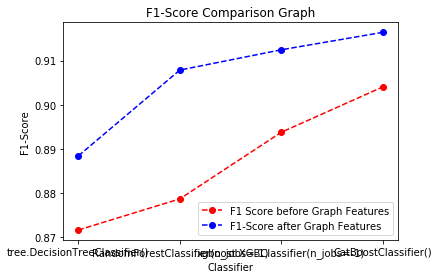

In [66]:
x1 = list(avg_f1_orig.keys())
y1 = list(avg_f1_orig.values())
plt.plot(x1, y1, 'ro', linestyle='dashed')

x2 = list(avg_f1_features.keys())
y2 = list(avg_f1_features.values())
plt.plot(x2, y2, 'bo', linestyle='dashed')

plt.savefig("out_accuracy.png")
plt.legend(['F1 Score before Graph Features', 'F1-Score after Graph Features'])
plt.title('F1-Score Comparison Graph')
plt.xlabel('Classifier')
plt.ylabel('F1-Score')
plt.savefig
plt.show()


## Plot the F1-Score comparison graphs

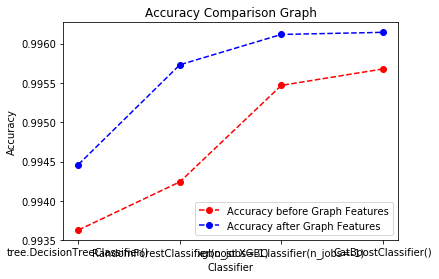

In [65]:
x1 = list(avg_accuracy_orig.keys())
y1 = list(avg_accuracy_orig.values())
plt.plot(x1, y1,  'ro', linestyle='dashed')

x2 = list(avg_accuracy_features.keys())
y2 = list(avg_accuracy_features.values())
plt.plot(x2, y2,  'bo', linestyle='dashed')


plt.savefig("out_f1.png")
plt.legend(['Accuracy before Graph Features', 'Accuracy after Graph Features'])
plt.title('Accuracy Comparison Graph')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.savefig
plt.show()